In [14]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from astropy.io import fits
from astropy.table import Table, Column, join

plt.rcParams['figure.figsize'] = (20, 10)

In [2]:
hdulist = fits.open('/home/aalvarez/Work/Data/WillPP/TargetPP.fits', hdu=1)
t = Table(hdulist[1].data)

In [3]:
target = Table.read('/home/aalvarez/Work/Data/WillPP/Target.fits')

In [4]:
merged = join(t, target, 'ID')
zdif = merged['REDSHIFT_MEDIAN'][:,0] - merged['Z']

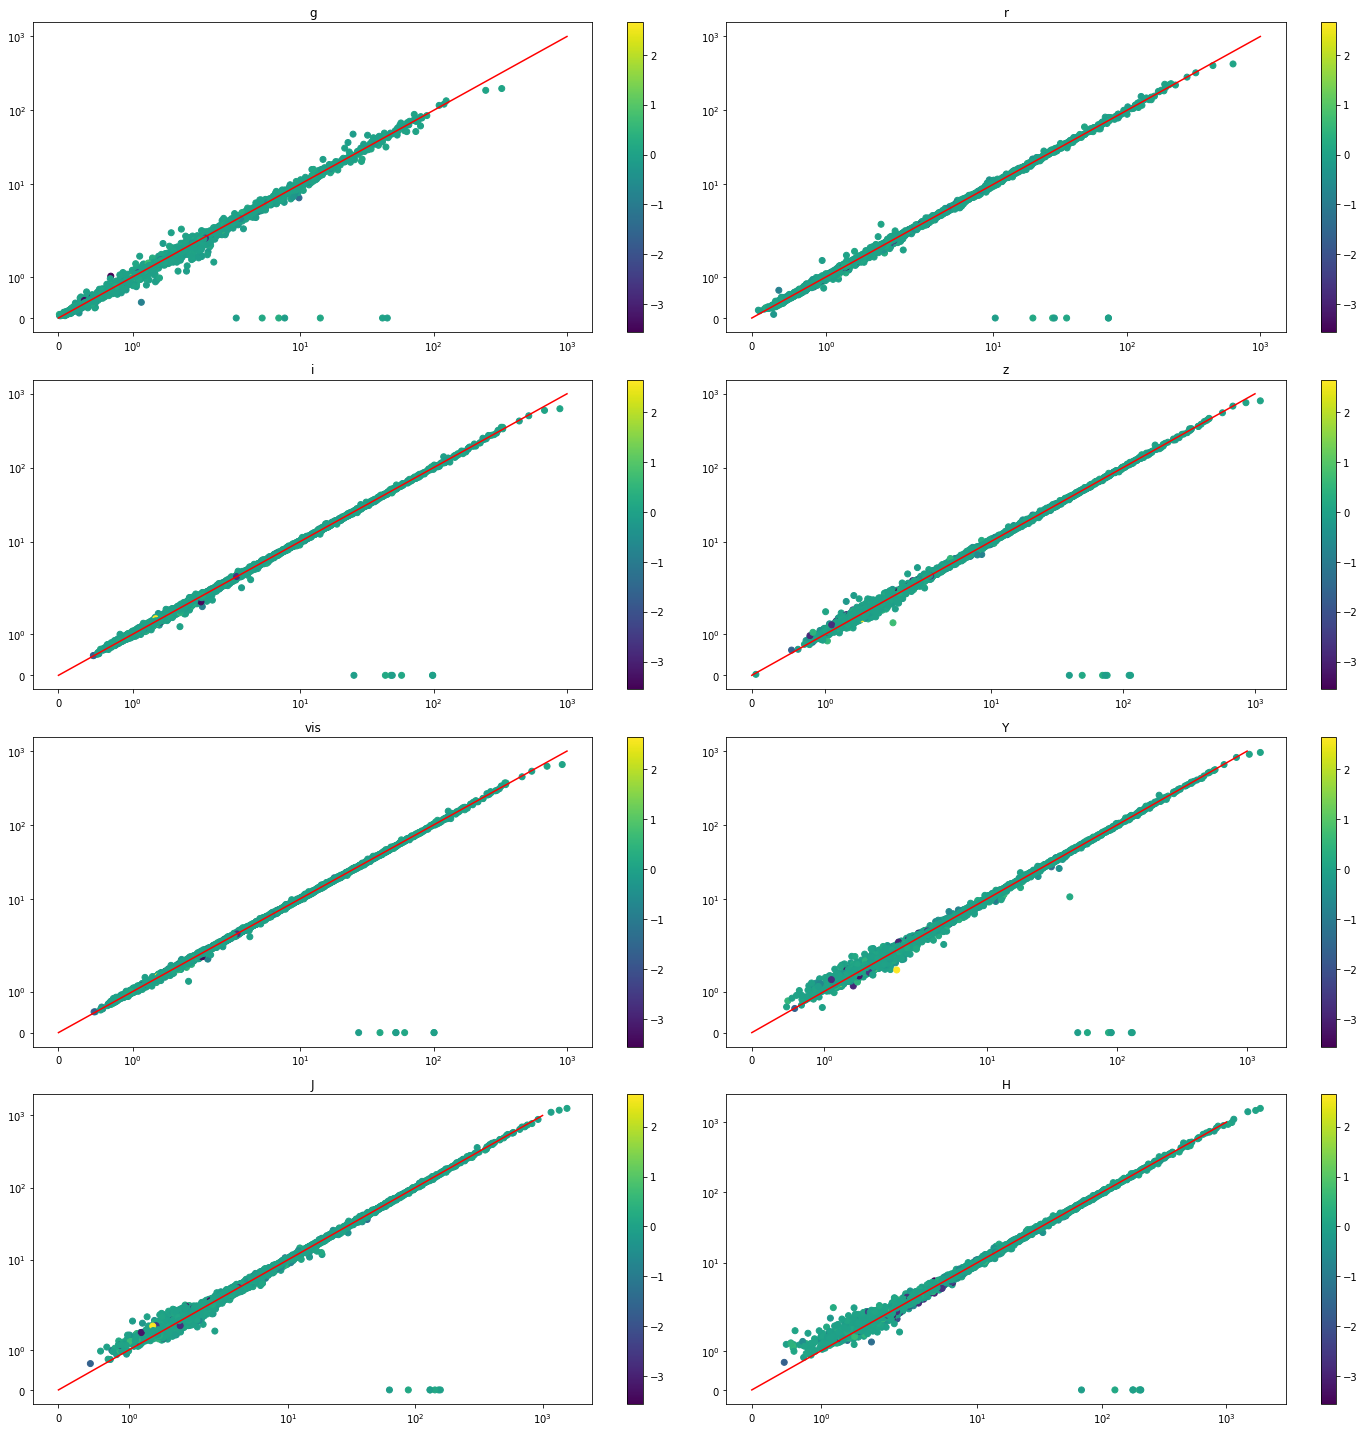

In [5]:
bands = ['g', 'r', 'i', 'z', 'vis', 'Y', 'J', 'H']

fig, axes = plt.subplots(ncols=2, nrows=len(bands)//2 + len(bands)%2, figsize=(20,20))

for b, ax in zip(bands, axes.ravel()):
    sc = ax.scatter(merged[f'Flux_{b}'], merged[f'Flux_{b}_MEAN'], c=zdif)
    ax.plot([0, 1e3], [0, 1e3], c='red')
    plt.colorbar(sc, ax=ax)
    ax.set_xscale('symlog')
    ax.set_yscale('symlog')
    ax.set_title(b)
plt.tight_layout()

/opt/miniconda3/envs/phz/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log10
  


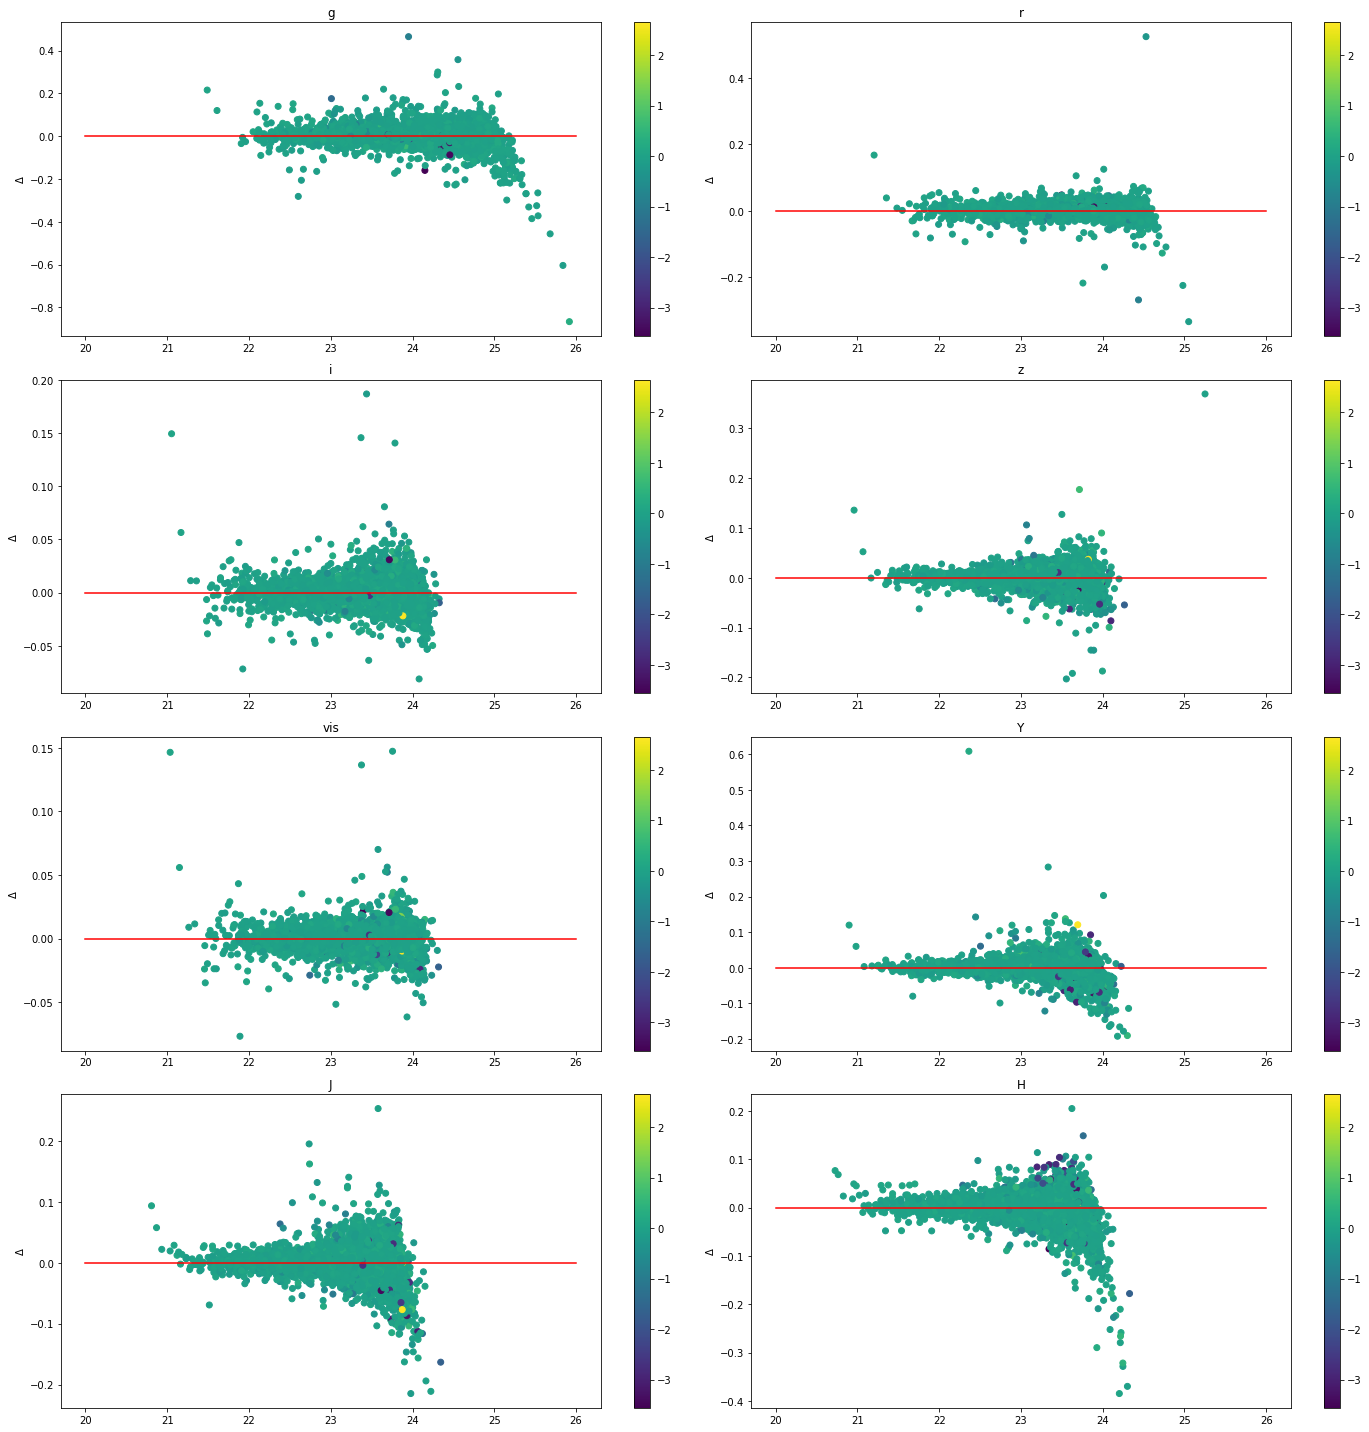

In [6]:
fig, axes = plt.subplots(ncols=2, nrows=len(bands)//2 + len(bands)%2, figsize=(20,20))

for b, ax in zip(bands, axes.ravel()):
    sc = ax.scatter(
        24-np.log10(merged[f'Flux_{b}']),
        np.log10(merged[f'Flux_{b}'])-np.log10(merged[f'Flux_{b}_MEAN']),
        c=zdif
    )
    ax.plot([20, 26], [0, 0], c='red')
    plt.colorbar(sc, ax=ax)
    ax.set_ylabel('$\Delta$')
    ax.set_title(b)
plt.tight_layout()

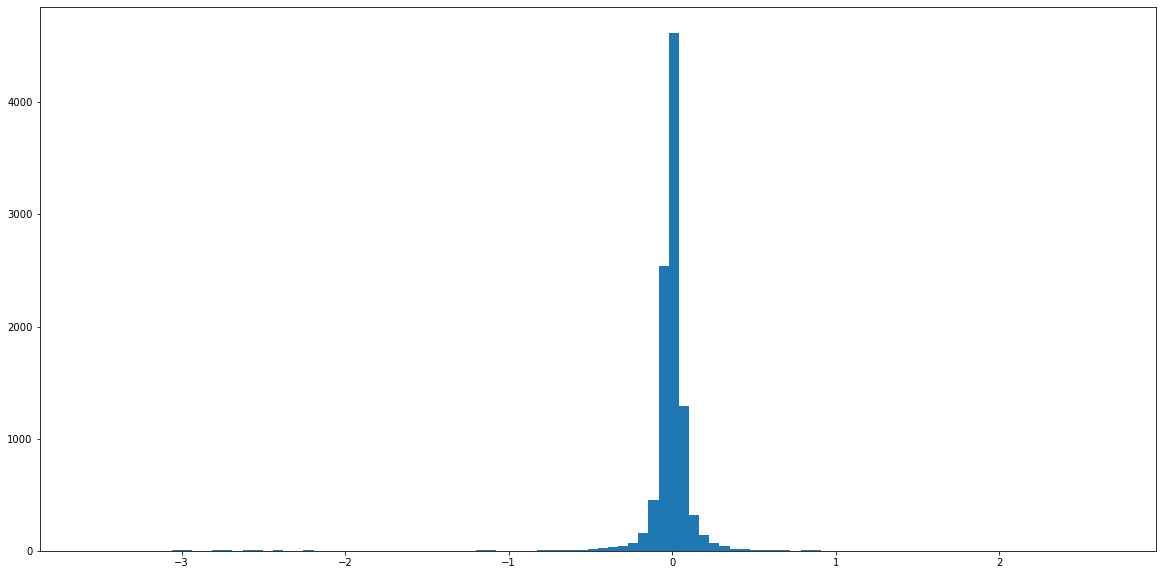

In [15]:
plt.figure()
plt.hist(zdif, bins=100)
plt.show()

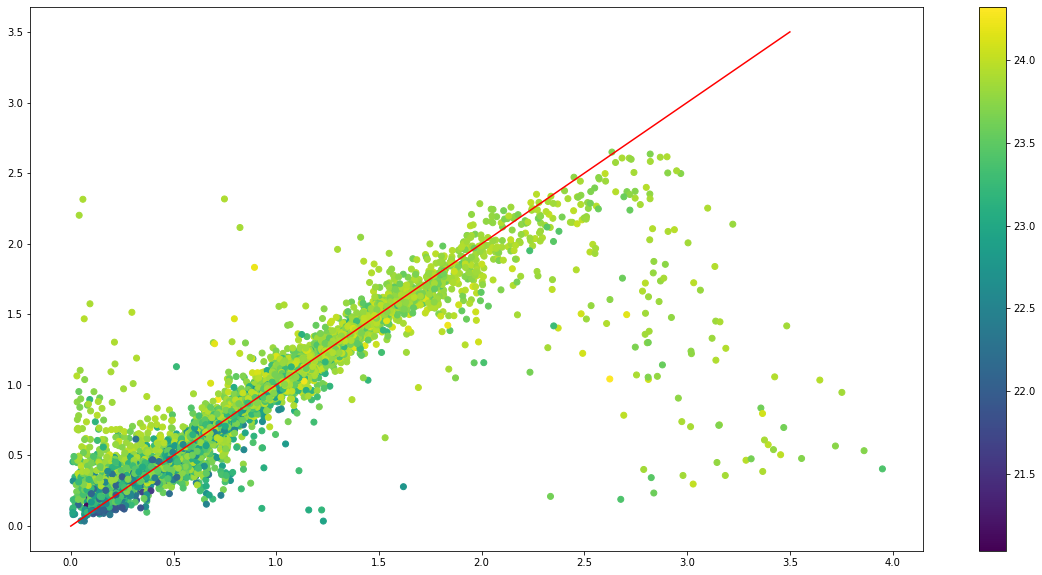

In [16]:
plt.figure()
plt.scatter(merged['Z'], merged['REDSHIFT_MEAN'], c=24-np.log10(merged['Flux_vis']))
plt.plot([0,3.5], [0,3.5], c='red')
plt.colorbar()

In [17]:
original = np.load('/home/aalvarez/Work/Data/WillPP/mc_data_0.npy', mmap_mode='r')
origi_pdz = np.load('/home/aalvarez/Work/Data/WillPP/pdz_data_0.npy', mmap_mode='r')

In [18]:
idx = np.arange(len(t))
np.random.shuffle(idx)

In [22]:
def plot_pp_pdf(name, nobjects=7):
    fig, axes = plt.subplots(ncols=3, nrows=nobjects, figsize=(20, 20))
    fig.suptitle(name)

    bins = hdulist[f'BINS_MC_PDF_1D_{name}'].data['BINS_PDF']
    pdz_bins = hdulist['BINS_PDF'].data['BINS_PDF']
    
    bins2d = hdulist[f'BINS_MC_PDF_2D_Z_{name}']
    xx = bins2d.data['Z'].reshape(99,99)
    yy = bins2d.data[name].reshape(99,99)
    
    for o, ax in zip(t[idx[:nobjects]], axes):
        true = original[o['ID']]
        v2d = o[f'MC_PDF_2D_Z_{name}'].reshape(99,99)
        opdz = origi_pdz[o['ID']+1]
        opdz = opdz/np.trapz(opdz, pdz_bins)
        
        ax[0].hist(true[name], bins=(bins - (bins[1]-bins[0])/2), density=True, label='True')
        ax[0].plot(bins, o[f'MC_PDF_1D_{name}'], label='Reconstructed')
        ax[0].legend()
        
        ax[1].set_title(f'PDZ {o["FLAGS_1"]}')
        ax[1].plot(pdz_bins, opdz, label='True')
        ax[1].plot(pdz_bins, o['REDSHIFT_PDF'], label='Reconstructed')
        ax[1].axvline(true['Z'].mean(), color='red', label='Z', linestyle=':')
        ax[1].legend()
        
        ax[2].contour(xx, yy, v2d)
        ax[2].set_xlabel('Z')
        ax[2].set_ylabel(name)
        
    plt.tight_layout()

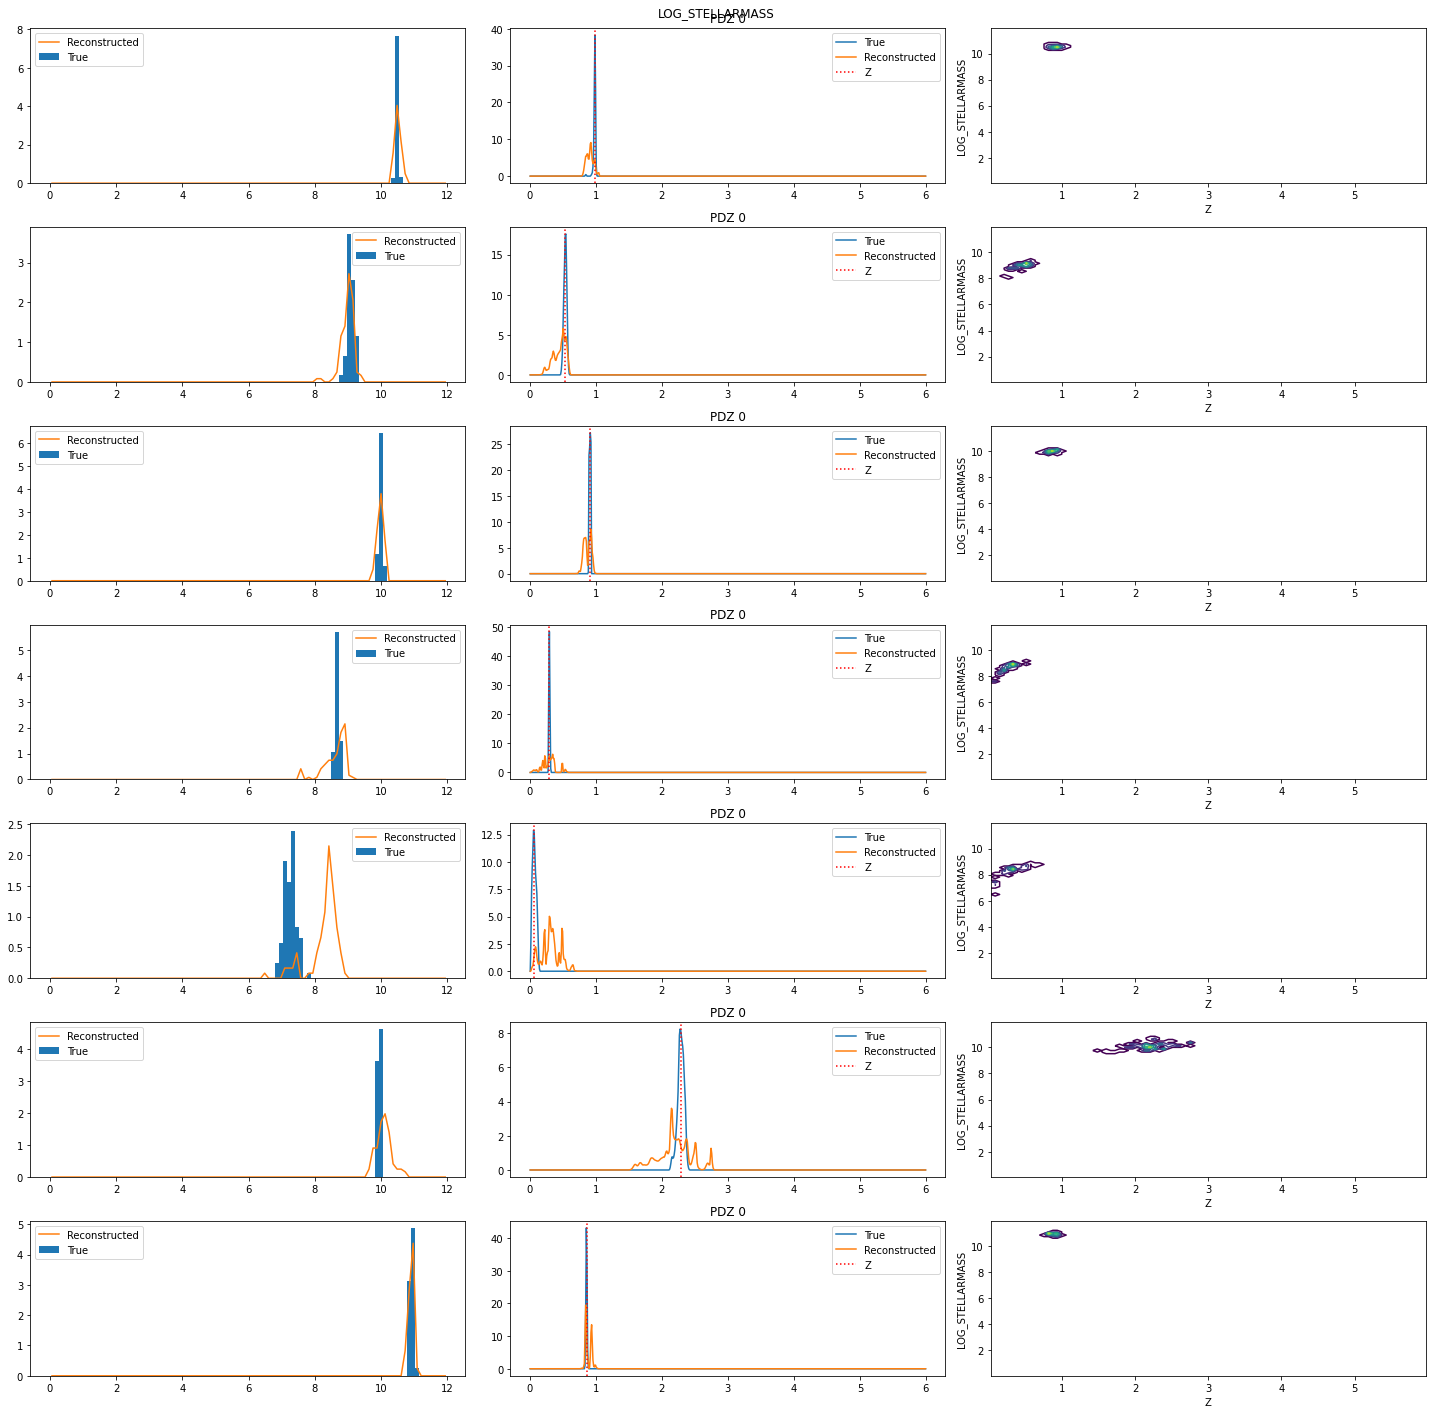

In [23]:
plot_pp_pdf('LOG_STELLARMASS')

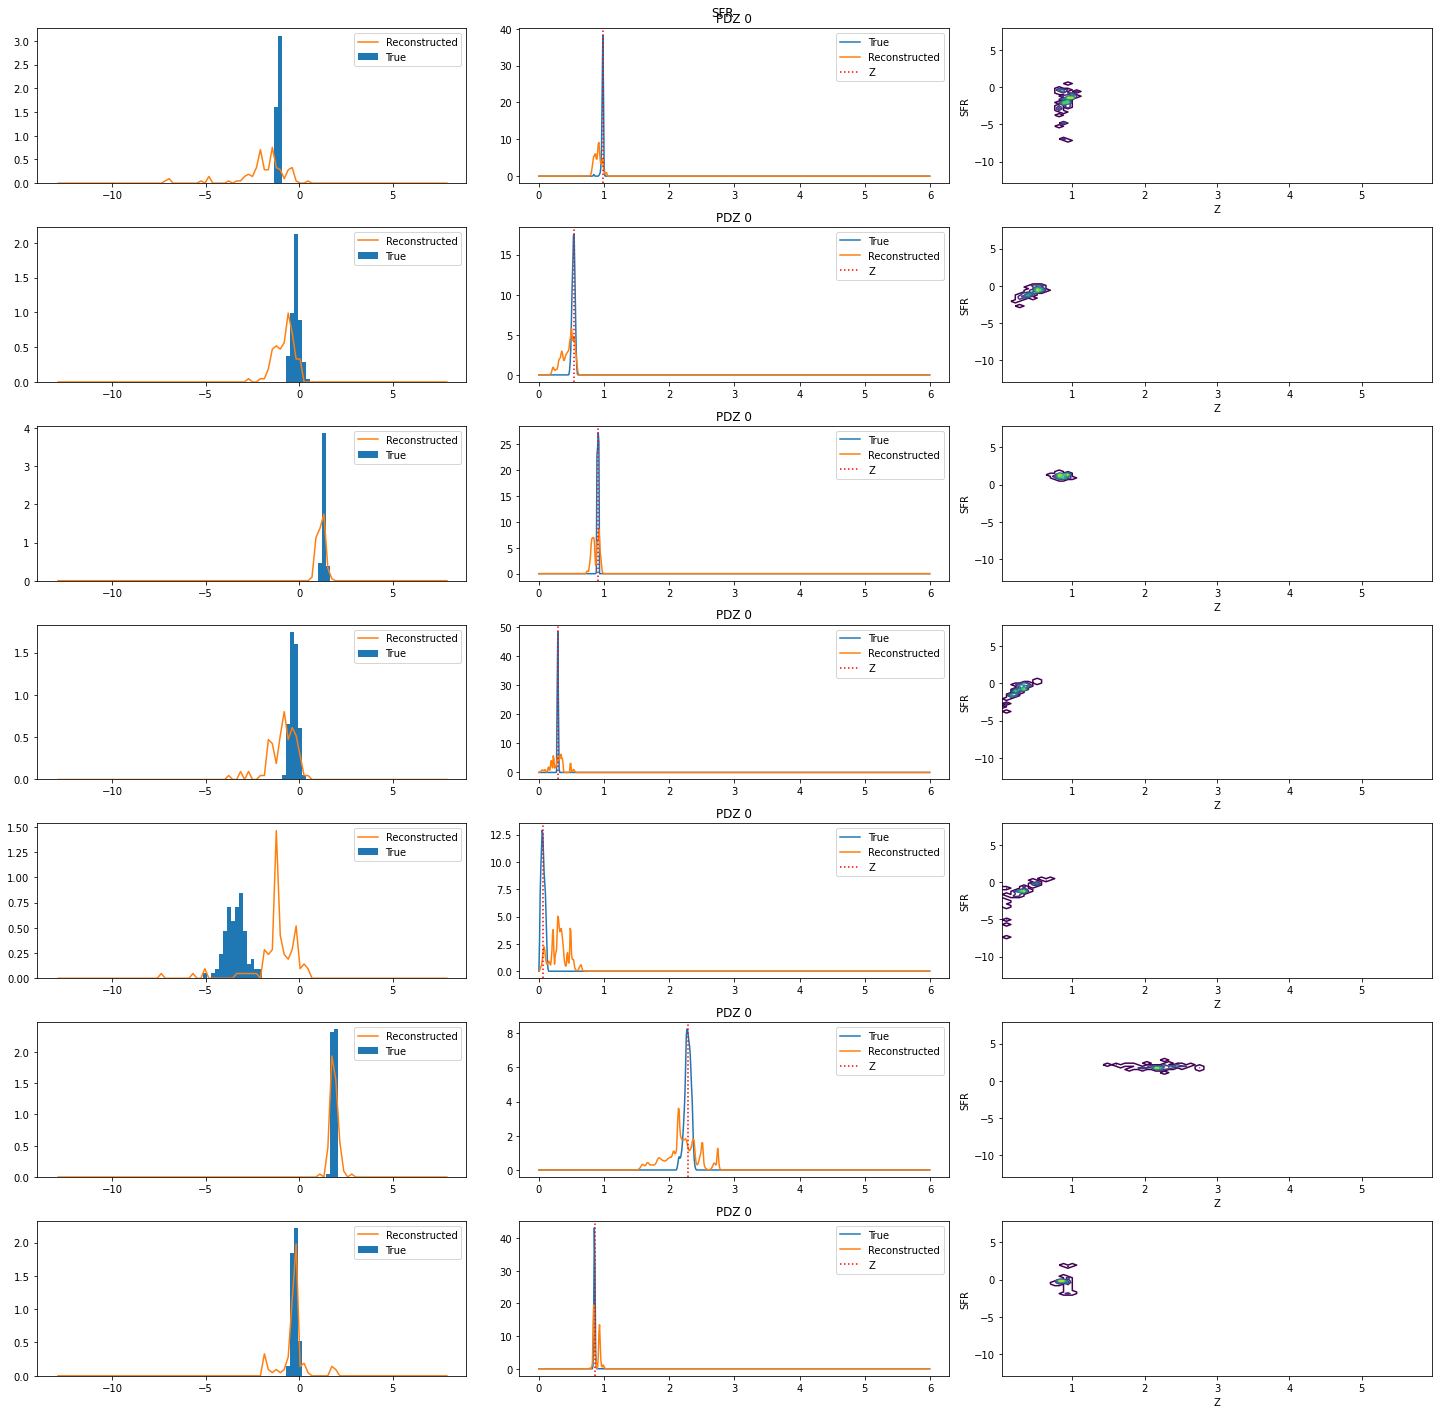

In [24]:
plot_pp_pdf('SFR')